# This file contains all the code for each research question


In [435]:
# FINAL RQ 1

import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load data 
df = pd.read_csv("./dataframes/final_versions/static_combined.csv", sep="\t")

# Create composite popularity score
df["sentiment_score"] = df["pos_mentions"] - df["neg_mentions"]  # if needed
df["mention_rank"] = df["total_mentions"].rank(ascending=False, method="min")
df["popularity_score"] = np.log(df["total_mentions"])

# Drop rows with missing values
df = df.dropna(subset=[
    "log_market_value", "rating_avg", "age", "height", 
    "popularity_score", "mention_rank", "sentiment_score"
])

# Update interaction terms if desired (optional)
df["interaction"] = df["rating_avg"] * df["popularity_score"]
df["rating_c"] = df["rating_avg"] - df["rating_avg"].mean()
df["popularity_c"] = df["popularity_score"] - df["popularity_score"].mean()
df["interaction_c"] = df["rating_c"] * df["popularity_c"]

# Response variable
y = df["log_market_value"]

# Define variable sets
characteristics = ["rating_avg", "age", "height", "national_team"]
extended = characteristics + ["popularity_score","sentiment_score"]
interaction = extended + ["interaction"]

# Run models
X_base = sm.add_constant(df[characteristics])
X_ext = sm.add_constant(df[extended])
X_interact = sm.add_constant(df[interaction])
X_interact_c = sm.add_constant(df[["rating_c", "popularity_c", "interaction_c", "sentiment_score"]])

# Fit models
model_base = sm.OLS(y, X_base).fit()
model_ext = sm.OLS(y, X_ext).fit()
model_interact = sm.OLS(y, X_interact).fit()
model_interact_c = sm.OLS(y, X_interact_c).fit()


# Print summaries
print("\n--- Base Model ---")
print(model_base.summary())

print("\n--- Extended Model ---")
print(model_ext.summary())

print("\n--- Interaction Model ---")
print(model_interact.summary())

print("\n--- Centered Interaction Model ---")
print(model_interact_c.summary())




--- Base Model ---
                            OLS Regression Results                            
Dep. Variable:       log_market_value   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     5.570
Date:                Tue, 24 Jun 2025   Prob (F-statistic):           0.000319
Time:                        16:58:59   Log-Likelihood:                -205.75
No. Observations:                 164   AIC:                             421.5
Df Residuals:                     159   BIC:                             437.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            16.5789  

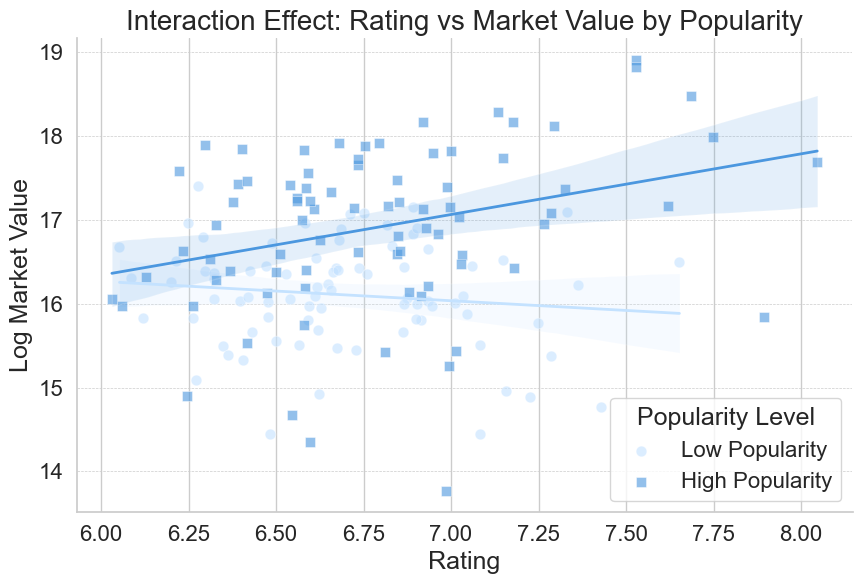

In [433]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by popularity (based on log total_mentions, i.e., popularity_score)
df["popularity_score"] = np.log(df["total_mentions"])

df["popularity_group"] = pd.qcut(df["popularity_score"], q=2, labels=["Low Popularity", "High Popularity"])

# Set up plot style
sns.set(style="whitegrid")
base_color = '#C4E2FF'
extended_color = '#4B97DF'

# Plot: Interaction between rating and popularity group
plot = sns.lmplot(
    data=df,
    x="rating_avg",
    y="log_market_value",
    hue="popularity_group",
    palette=[base_color, extended_color],
    height=6,
    aspect=1.2,
    scatter_kws={
        "s": 60,
        "alpha": 0.6,
        "edgecolors": "w",
        "linewidths": 0.5
    },
    line_kws={"linewidth": 2},
    markers=["o", "s"]
)

plot._legend.remove()

# Plot customization
plt.title("Interaction Effect: Rating vs Market Value by Popularity", fontsize=20)
plt.xlabel("Rating", fontsize=18)
plt.ylabel("Log Market Value", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title="Popularity Level", title_fontsize=18, fontsize=16, loc="lower right")
plt.grid(visible=True, axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [376]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS

# Load and preprocess
dailydf = pd.read_csv("./dataframes/final_versions/daily_encoded.csv", sep="\t")
dailydf['date'] = pd.to_datetime(dailydf['date'])
dailydf = dailydf.sort_values(['player_id', 'date'])
dailydf = dailydf.set_index(['player_id', 'date'])

# Sentiment scores
dailydf['sentiment_score'] = dailydf['pos_mentions'] - dailydf['neg_mentions']
dailydf['sentiment_X'] = dailydf['pos_X'] - dailydf['neg_X']
dailydf['sentiment_News'] = dailydf['pos_news'] - dailydf['neg_news']
dailydf['sentiment_Reddit'] = dailydf['pos_reddit'] - dailydf['neg_reddit']

# Peak popularity flags (2 std above mean)
for platform in ['total_X', 'total_news', 'total_reddit']:
    threshold = dailydf.groupby('player_id')[platform].transform(lambda x: x.mean() + 2 * x.std())
    dailydf[f'peak_{platform}'] = (dailydf[platform] > threshold).astype(int)

# Outcome: market value 30 days later
dailydf['market_value_30d_later'] = dailydf.groupby(level=0)['market_value'].shift(-30)

# Final features — same-day predictors
features = ['market_value_30d_later', 'sentiment_score', 'sentiment_X', 'sentiment_News', 'sentiment_Reddit',
            'total_mentions', 'peak_total_X', 'peak_total_news', 'peak_total_reddit',
            'rating', 'goal_total']

model_df = dailydf[features].dropna()

# Fixed effects regression
model = PanelOLS.from_formula(
    'market_value_30d_later ~ sentiment_score + sentiment_X + sentiment_News + sentiment_Reddit + total_mentions + peak_total_X + peak_total_news + peak_total_reddit + rating + goal_total + EntityEffects',
    data=model_df
)
results = model.fit()
print(results.summary)


                            PanelOLS Estimation Summary                             
Dep. Variable:     market_value_30d_later   R-squared:                        0.0030
Estimator:                       PanelOLS   R-squared (Between):              0.0407
No. Observations:                   49036   R-squared (Within):               0.0030
Date:                    Mon, Jun 23 2025   R-squared (Overall):              0.0397
Time:                            21:12:06   Log-likelihood                -8.267e+05
Cov. Estimator:                Unadjusted                                           
                                            F-statistic:                      14.743
Entities:                             199   P-value                           0.0000
Avg Obs:                           246.41   Distribution:                F(10,48827)
Min Obs:                           245.00                                           
Max Obs:                           526.00   F-statistic (robust):

In [381]:
# FINAL PEAK

import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS

# Load and prepare data
df = pd.read_csv("./dataframes/final_versions/daily_final.csv", sep="\t")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['player_id', 'date']).set_index(['player_id', 'date'])

# Log-transform market value
df['market_value_log'] = np.log(df['market_value'])

# Calculate 60-day future change
df['market_value_log_60d_later'] = df.groupby(level=0)['market_value_log'].shift(-60)
df['delta_value'] = df['market_value_log_60d_later'] - df['market_value_log']

# Create peak indicators (2 std above mean)
for platform in ['total_mentions', 'total_news', 'total_X', 'total_reddit']:
    threshold = df.groupby('player_id')[platform].transform(lambda x: x.mean() + 2 * x.std())
    df[f'peak_{platform}'] = (df[platform] > threshold).astype(int)

# Subset and drop NA
peak_vars = [col for col in df.columns if col.startswith('peak_')]
model_df = df[['delta_value'] + ['rating'] + peak_vars].dropna()

# Run fixed-effects panel regression
model = PanelOLS.from_formula(
    'delta_value ~ ' + ' + '.join(peak_vars) + ' + rating + EntityEffects',
    data=model_df
)
results = model.fit()
print(results.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:            delta_value   R-squared:                        0.0068
Estimator:                   PanelOLS   R-squared (Between):              0.3182
No. Observations:               35260   R-squared (Within):               0.0068
Date:                Mon, Jun 23 2025   R-squared (Overall):              0.1789
Time:                        22:26:43   Log-likelihood                    5495.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      48.068
Entities:                         164   P-value                           0.0000
Avg Obs:                       215.00   Distribution:                 F(5,35091)
Min Obs:                       215.00                                           
Max Obs:                       215.00   F-statistic (robust):             48.068
                            

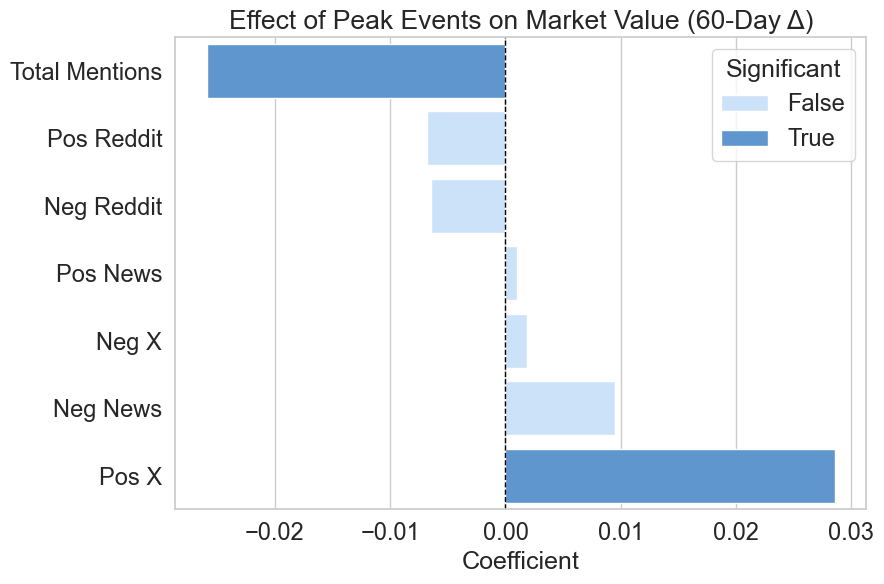

In [386]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract coefficients and p-values from model
params = results.params
pvalues = results.pvalues

# Filter only peak variables
peak_vars = [var for var in params.index if "peak_" in var]

# Create DataFrame for plotting
df_plot = pd.DataFrame({
    "Variable": peak_vars,
    "Coefficient": [params[var] for var in peak_vars],
    "p_value": [pvalues[var] for var in peak_vars]
})

# Mark significance
df_plot["Significant"] = df_plot["p_value"] < 0.05

# Clean labels
df_plot["Platform"] = df_plot["Variable"].str.replace("peak_", "").str.replace("_", " ").str.title()

# === Plotting ===
sns.set(style="whitegrid")
plt.figure(figsize=(9, 6))
sns.barplot(
    data=df_plot.sort_values("Coefficient"),
    x="Coefficient",
    y="Platform",
    hue="Significant",
    palette={True: '#4B97DF', False: '#C4E2FF'}
)

# Formatting
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title("Effect of Peak Events on Market Value (60-Day Δ)", fontsize=19)
plt.xlabel("Coefficient", fontsize=18)
plt.ylabel("", fontsize=18)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(title="Significant", title_fontsize=18, fontsize=17, loc="upper right")
plt.tight_layout()
plt.show()


In [383]:
# FINAL SENTIMENT PEAK

import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS

# Load and prepare data
df = pd.read_csv("./dataframes/final_versions/daily_final.csv", sep="\t")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['player_id', 'date']).set_index(['player_id', 'date'])

# Log-transform market value
df['market_value_log'] = np.log(df['market_value'])

# Calculate 30-day future change
df['market_value_log_30d_later'] = df.groupby(level=0)['market_value_log'].shift(-60)
df['delta_value'] = df['market_value_log_30d_later'] - df['market_value_log']

# Create peak indicators (2 std above mean)
for platform in ['total_mentions', 'pos_news', 'neg_news', 'pos_X', 'neg_X', 'pos_reddit', 'neg_reddit']:
    threshold = df.groupby('player_id')[platform].transform(lambda x: x.mean() + 2 * x.std())
    df[f'peak_{platform}'] = (df[platform] > threshold).astype(int)

# Subset and drop NA
peak_vars = [col for col in df.columns if col.startswith('peak_')]
model_df = df[['delta_value'] + ['rating'] + peak_vars].dropna()

# Run fixed-effects panel regression
model = PanelOLS.from_formula(
    'delta_value ~ ' + ' + '.join(peak_vars) + ' + rating + EntityEffects',
    data=model_df
)
results = model.fit()
print(results.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:            delta_value   R-squared:                        0.0071
Estimator:                   PanelOLS   R-squared (Between):              0.3183
No. Observations:               35260   R-squared (Within):               0.0071
Date:                Mon, Jun 23 2025   R-squared (Overall):              0.1791
Time:                        22:27:04   Log-likelihood                    5501.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      31.511
Entities:                         164   P-value                           0.0000
Avg Obs:                       215.00   Distribution:                 F(8,35088)
Min Obs:                       215.00                                           
Max Obs:                       215.00   F-statistic (robust):             31.511
                            


====== RUN 1 ======

Tuning Random Forest...


Tuning XGBoost...
Tuning CatBoost...


/Users/vivian.witting/Documents/github/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/vivian.witting/Documents/github/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Tuning GBDT...

====== RUN 2 ======

Tuning Random Forest...
Tuning XGBoost...


/Users/vivian.witting/Documents/github/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/vivian.witting/Documents/github/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Tuning CatBoost...


/Users/vivian.witting/Documents/github/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Tuning GBDT...

====== RUN 3 ======

Tuning Random Forest...
Tuning XGBoost...


/Users/vivian.witting/Documents/github/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/vivian.witting/Documents/github/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Tuning CatBoost...


/Users/vivian.witting/Documents/github/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Tuning GBDT...

 Average results over 3 runs
Random Forest:
  Base R²: 0.0621
  Extended R²: 0.4642
  Base RMSE: 1.0063
  Extended RMSE: 0.7619
  Base MAE: 0.7904
  Extended MAE: 0.5662
  R² Improvement: 0.4021
  Best Params: {'max_depth': 15, 'n_estimators': 500}
XGBoost:
  Base R²: 0.0393
  Extended R²: 0.4557
  Base RMSE: 1.0161
  Extended RMSE: 0.7659
  Base MAE: 0.8045
  Extended MAE: 0.5797
  R² Improvement: 0.4164
  Best Params: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300}
CatBoost:
  Base R²: 0.1336
  Extended R²: 0.4630
  Base RMSE: 0.9691
  Extended RMSE: 0.7626
  Base MAE: 0.7704
  Extended MAE: 0.5575
  R² Improvement: 0.3295
  Best Params: {'depth': 6, 'iterations': 600, 'learning_rate': 0.01}
GBDT:
  Base R²: 0.0710
  Extended R²: 0.4244
  Base RMSE: 1.0030
  Extended RMSE: 0.7889
  Base MAE: 0.8008
  Extended MAE: 0.5881
  R² Improvement: 0.3534
  Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}


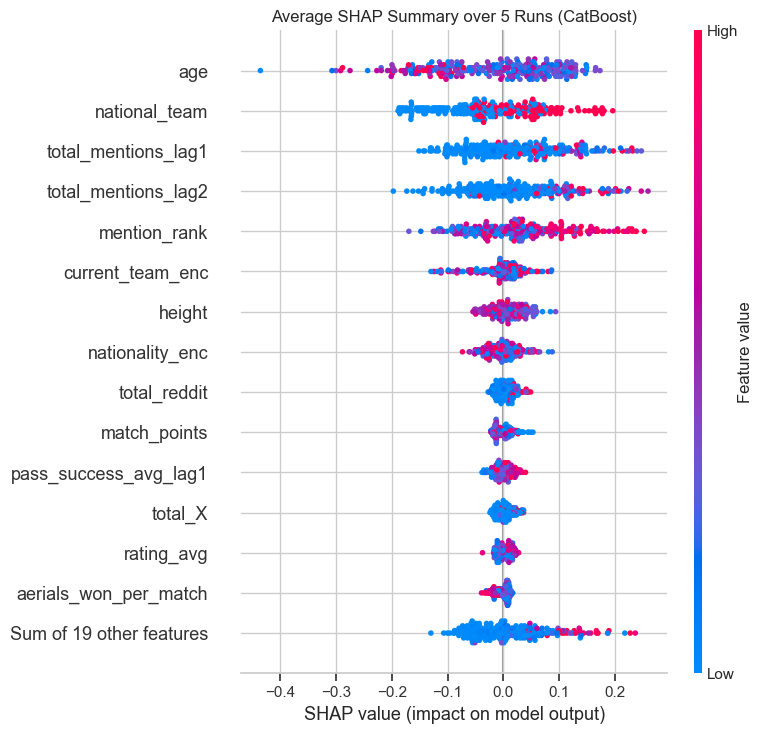

In [ ]:
# FINAL RQ3

import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from collections import defaultdict
import shap
import matplotlib.pyplot as plt

# Load data and add features
df = pd.read_csv("./dataframes/final_versions/monthly_final.csv", sep="\t").dropna()
df = df.sort_values(by=["player_id", "month"])

# Feature engineering
df["mention_rank"] = df.groupby("month")["total_mentions"].rank(pct=True)
df["sentiment"] = df["pos_mentions"] - df["neg_mentions"]
df["score_rate"] = np.where(df["shots_per_match"] > 0,
                            df["goals_per_match"] / df["shots_per_match"],
                            0)



# Define feature sets
base_features = ["age", "height", "nationality_enc", "national_team", "current_team_enc"]
performance_features = [
    "goals_per_match", "goals_per_match_lag1", "assists_per_match", "shots_per_match", 
    "aerials_won_per_match", "pass_success_avg", "rating_avg", "rating_avg_lag1", "pass_success_avg_lag1",
    "match_points", "mins_played_avg", "score_rate"
]
popularity_features = [
    "total_mentions", "pos_mentions", "neg_mentions", "mention_rank", "sentiment",
    "total_X", "pos_X", "neg_X", "total_mentions_lag1", "total_mentions_lag2",
    "total_news", "pos_news", "neg_news",
    "total_reddit", "pos_reddit", "neg_reddit"
]

X_base = df[base_features + performance_features]
X_extended = df[base_features + performance_features + popularity_features]

y = df["log_market_value"]
groups = df["player_id"]

# Model setup
models_and_params = {
    "Random Forest": (
        RandomForestRegressor(random_state=42),
        {"n_estimators": [400, 500], "max_depth": [15, 20]}
    ),
    "XGBoost": (
        XGBRegressor(random_state=42, verbosity=0),
        {"n_estimators": [300, 400], "max_depth": [6, 12], "learning_rate": [0.1, 0.05, 0.01]}
    ),
    "CatBoost": (
        CatBoostRegressor(verbose=0, random_seed=42),
        {"depth": [6], "learning_rate": [0.1, 0.05, 0.01], "iterations": [500, 600]}
    ),
    "GBDT": (
        GradientBoostingRegressor(random_state=42),
        {"n_estimators": [200, 300], "max_depth": [3, 6], "learning_rate": [0.1, 0.05, 0.01]}
    )
}

# Train
n_runs = 5
all_results = defaultdict(list)
all_shap_values = []

for run in range(n_runs):
    print(f"\nRUN {run + 1} \n")
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=run)
    train_idx, test_idx = next(gss.split(X_extended, y, groups))

    X_train_base, X_test_base = X_base.iloc[train_idx], X_base.iloc[test_idx]
    X_train_ext, X_test_ext = X_extended.iloc[train_idx], X_extended.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    group_train = groups.iloc[train_idx]

    for name, (model, param_grid) in models_and_params.items():
        print(f"Tuning {name}...")

        gkf = GroupKFold(n_splits=5)
        grid_base = GridSearchCV(model, param_grid, scoring='r2',
                                 cv=gkf.split(X_train_base, y_train, group_train), n_jobs=-1)
        grid_ext = GridSearchCV(model, param_grid, scoring='r2',
                                cv=gkf.split(X_train_ext, y_train, group_train), n_jobs=-1)



        grid_base.fit(X_train_base, y_train)
        grid_ext.fit(X_train_ext, y_train)

        best_base = grid_base.best_estimator_
        best_ext = grid_ext.best_estimator_


        y_pred_base = best_base.predict(X_test_base)
        y_pred_ext = best_ext.predict(X_test_ext)

        all_results[name].append({
            "Base R²": r2_score(y_test, y_pred_base),
            "Extended R²": r2_score(y_test, y_pred_ext),
            "Base RMSE": np.sqrt(mean_squared_error(y_test, y_pred_base)),
            "Extended RMSE": np.sqrt(mean_squared_error(y_test, y_pred_ext)),
            "Base MAE": mean_absolute_error(y_test, y_pred_base),
            "Extended MAE": mean_absolute_error(y_test, y_pred_ext),
            "R² Improvement": r2_score(y_test, y_pred_ext) - r2_score(y_test, y_pred_base),
            "Best Params": grid_ext.best_params_
        })


        if name == "CatBoost":
            shap_sample = X_test_ext.sample(n=min(1000, len(X_test_ext)), random_state=run)
            explainer = shap.Explainer(best_ext)
            shap_values = explainer(shap_sample)
            all_shap_values.append(shap_values)

# Get summary
print("\n Average results over 5 runs")
for model_name, results in all_results.items():
    print(f"{model_name}:")
    
    avg_metrics = {}
    for k in results[0].keys():
        if isinstance(results[0][k], dict):
            avg_metrics[k] = results[0][k]  # just show first config
        else:
            avg_metrics[k] = np.mean([r[k] for r in results])

    for k, v in avg_metrics.items():
        if isinstance(v, dict):
            print(f"  {k}: {v}")
        else:
            print(f"  {k}: {v:.4f}")


# SHAP Plot
mean_shap = np.mean([s.values for s in all_shap_values], axis=0)
mean_shap_values = shap.Explanation(
    values=mean_shap,
    base_values=all_shap_values[0].base_values,
    data=all_shap_values[0].data,
    feature_names=all_shap_values[0].feature_names
)

plt.figure(figsize=(10, 6))
shap.plots.beeswarm(mean_shap_values, max_display=15, show=False)
plt.title("Average SHAP Summary over 5 Runs (CatBoost)")
plt.tight_layout()
plt.show()



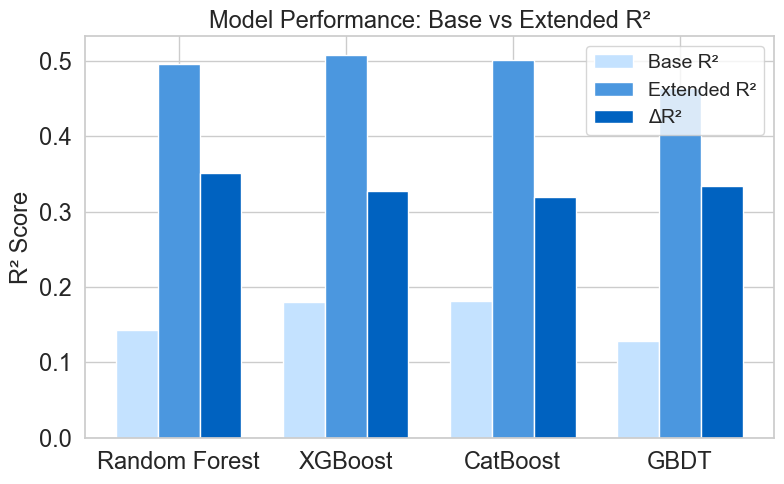

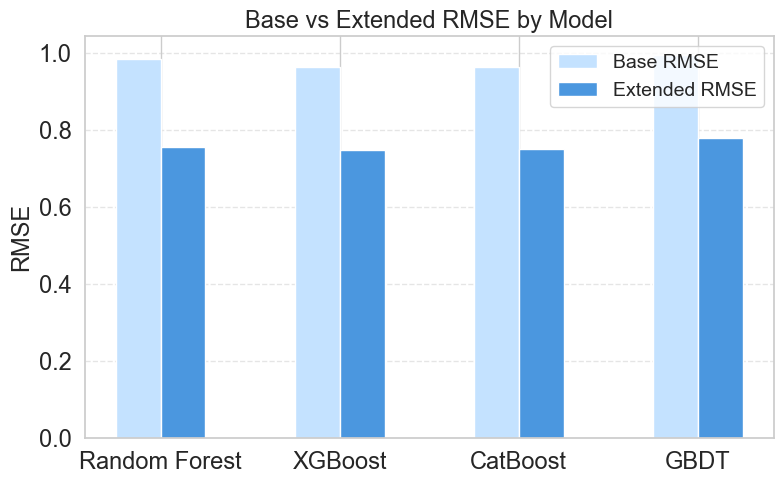

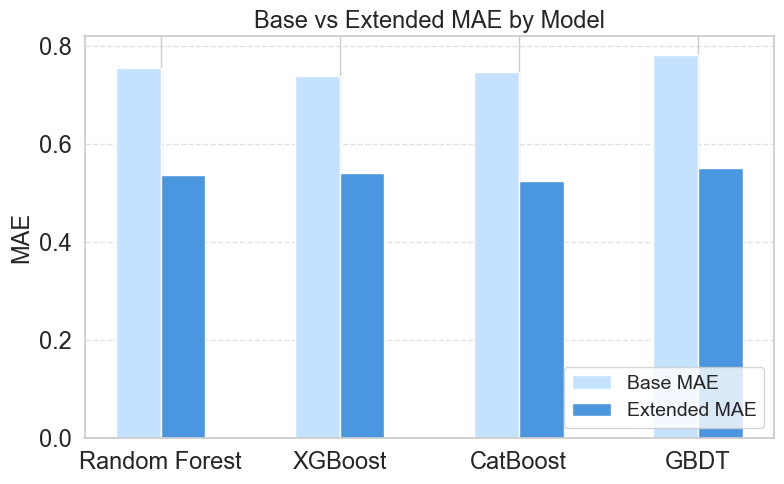

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Updated Data 
data = {
    "Model": ["Random Forest", "XGBoost", "CatBoost", "GBDT"],
    "Base R²": [0.1436, 0.1802, 0.1820, 0.1290],
    "Extended R²": [0.4956, 0.5075, 0.5013, 0.4638],
    "ΔR²": [0.3520, 0.3274, 0.3192, 0.3348],
    "Base RMSE": [0.9846, 0.9639, 0.9628, 0.9933],
    "Extended RMSE": [0.7560, 0.7469, 0.7515, 0.7787],
    "Base MAE": [0.7551, 0.7393, 0.7482, 0.7810],
    "Extended MAE": [0.5367, 0.5411, 0.5239, 0.5504],
}
df = pd.DataFrame(data)
x = np.arange(len(df))
bar_width = 0.25
sizef = 17
sizes = 14

# R² Comparison Plot 
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - bar_width, df["Base R²"], width=bar_width, label='Base R²', color='#C4E2FF')
ax.bar(x, df["Extended R²"], width=bar_width, label='Extended R²', color='#4B97DF')
ax.bar(x + bar_width, df["ΔR²"], width=bar_width, label='ΔR²', color='#0062C0')
ax.set_xticks(x)
ax.set_xticklabels(df["Model"], fontsize=sizef)
ax.set_ylabel("R² Score", fontsize=sizef)
ax.set_title("Model Performance: Base vs Extended R²", fontsize=sizef)
ax.legend(fontsize=sizes, loc="upper right")
ax.tick_params(axis='y', labelsize=sizef)
ax.axhline(0, color='grey', linewidth=0.5, linestyle='--')
plt.tight_layout()
plt.show()

# RMSE Comparison Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - bar_width/2, df["Base RMSE"], width=bar_width, label='Base RMSE', color='#C4E2FF')
ax.bar(x + bar_width/2, df["Extended RMSE"], width=bar_width, label='Extended RMSE', color='#4B97DF')
ax.set_xticks(x)
ax.set_xticklabels(df["Model"], fontsize=sizef)
ax.set_ylabel("RMSE", fontsize=sizef)
ax.set_title("Base vs Extended RMSE by Model", fontsize=sizef)
ax.legend(fontsize=sizes, loc="upper right")
ax.grid(True, axis='y', linestyle='--', alpha=0.5)
ax.tick_params(axis='y', labelsize=sizef)
plt.tight_layout()
plt.show()

# MAE Comparison Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - bar_width/2, df["Base MAE"], width=bar_width, label='Base MAE', color='#C4E2FF')
ax.bar(x + bar_width/2, df["Extended MAE"], width=bar_width, label='Extended MAE', color='#4B97DF')
ax.set_xticks(x)
ax.set_xticklabels(df["Model"], fontsize=sizef)
ax.set_ylabel("MAE", fontsize=sizef)
ax.set_title("Base vs Extended MAE by Model", fontsize=sizef)
ax.legend(fontsize=sizes, loc="lower right")
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
ax.tick_params(axis='y', labelsize=sizef)
plt.tight_layout()
plt.show()


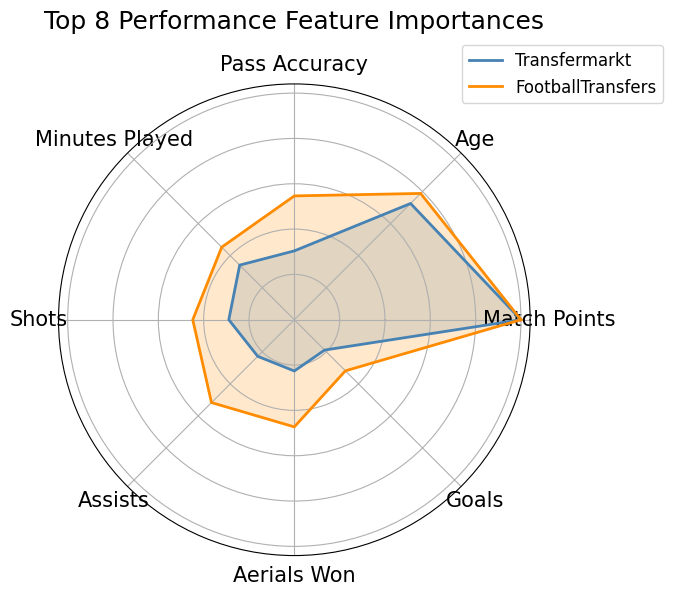

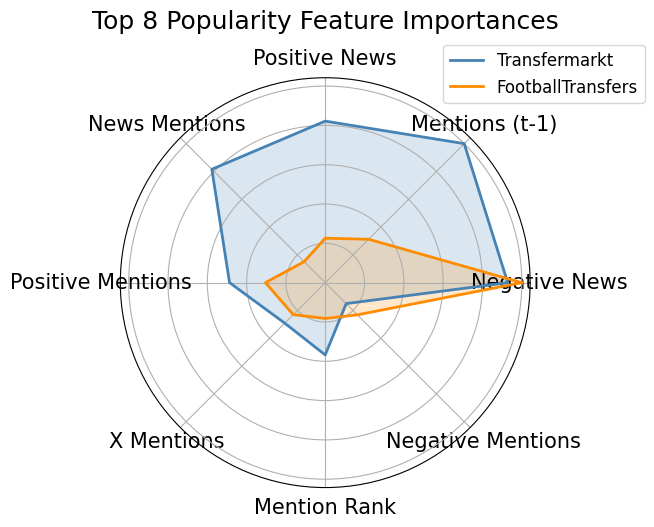

In [1]:
# FINAL RQ 4

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# === Load and preprocess data ===
df = pd.read_csv("./dataframes/final_versions/static_combined.csv", sep="\t")
df = df.dropna(subset=["transfermarkt", "footballtransfer"])

# Feature engineering
df["mention_rank"] = df.groupby("month")["total_mentions"].rank(pct=True)
df["sentiment"] = df["pos_mentions"] - df["neg_mentions"]

# Feature groups
performance_features = [
    'goals_per_match', 'assists_per_match', 'shots_per_match',
    'aerials_won_per_match', 'pass_success_avg', 'rating_avg',
    'match_points', 'mins_played_avg', 'age'
]

popularity_features = [
    'total_mentions', 'pos_mentions', 'neg_mentions', 'mention_rank',
    'total_X', 'sentiment', 'total_news', 'pos_news', 'neg_news',
    'total_mentions_lag1', 'pos_X', 'neg_X', 'total_reddit', 'pos_reddit', 'neg_reddit'
]

# Prepare data
X = df[performance_features + popularity_features]
y_tm = df["transfermarkt"]
y_ft = df["footballtransfer"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Train models
rf_tm = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_scaled_df, y_tm)
rf_ft = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_scaled_df, y_ft)

# Feature importances
fi_tm = pd.Series(rf_tm.feature_importances_, index=X.columns)
fi_ft = pd.Series(rf_ft.feature_importances_, index=X.columns)

# Normalize for radar
def normalize(series):
    return series / series.max()

# Select top 8 performance features by mean importance
perf_mean = (fi_tm[performance_features] + fi_ft[performance_features]) / 2
top_perf = perf_mean.sort_values(ascending=False).head(8).index.tolist()

# Select top 8 popularity features by mean importance
pop_mean = (fi_tm[popularity_features] + fi_ft[popularity_features]) / 2
top_pop = pop_mean.sort_values(ascending=False).head(8).index.tolist()

perf_norm = pd.DataFrame({
    "Transfermarkt": normalize(fi_tm[top_perf]),
    "FootballTransfers": normalize(fi_ft[top_perf])
})

pop_norm = pd.DataFrame({
    "Transfermarkt": normalize(fi_tm[top_pop]),
    "FootballTransfers": normalize(fi_ft[top_pop])
})

# Radar plot function

rename_map = {
    "goals_per_match": "Goals",
    "assists_per_match": "Assists",
    "shots_per_match": "Shots",
    "aerials_won_per_match": "Aerials Won",
    "pass_success_avg": "Pass Accuracy",
    "rating_avg": "Rating",
    "match_points": "Match Points",
    "mins_played_avg": "Minutes Played",
    "age": "Age",
    "total_mentions": "Total Mentions",
    "pos_mentions": "Positive Mentions",
    "neg_mentions": "Negative Mentions",
    "mention_rank": "Mention Rank",
    "total_X": "X Mentions",
    "sentiment": "Sentiment",
    "total_news": "News Mentions",
    "pos_news": "Positive News",
    "neg_news": "Negative News",
    "insta_follows": "Instagram Followers",
    "total_mentions_lag1": "Mentions (t-1)"
}

# Rename index for plotting
perf_norm.rename(index=rename_map, inplace=True)
pop_norm.rename(index=rename_map, inplace=True)

def plot_double_radar(df, title):
    labels = df.index.tolist()
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))  # Increase figure size if needed
    for col, color in zip(df.columns, ["steelblue", "darkorange"]):
        values = df[col].tolist()
        values += values[:1]
        ax.plot(angles, values, label=col, linewidth=2, color=color)
        ax.fill(angles, values, alpha=0.2, color=color)

    ax.set_title(title, size=18, y=1.1)  # Bigger title
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=15)  # Axis label font size
    ax.set_yticklabels([])  # No radial labels
    ax.tick_params(axis='x', labelsize=15)  # Optional: set tick label font size
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=12)
 # Legend font size
    plt.tight_layout()
    plt.show()


# Plot top 8 radar charts
plot_double_radar(perf_norm, "Top 8 Performance Feature Importances")
plot_double_radar(pop_norm, "Top 8 Popularity Feature Importances")
